# Analyses post scrapping

Objectifs :
- on veut surveiller le nombre de concurrents
- ceux qui arrivent à vendre
- ceux qui changent de stratégie

In [15]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import datetime

In [108]:
villes = ['Arcueil', 'Bourg-la-Reine', 'Cachan']
df = pickle.load(open('tous_les_logements.p', 'rb')).drop('texte', axis=1)
df = df[df.ville.isin(villes)].copy()

print(df.shape)
df.tail(2)

(142, 11)


,date_enregistrement,type,ville,description,prix,note,nb_avis,nb_lits,nb_chambres,est_professionnel,est_nouveau
301,2023-12-25,Hébergement,Cachan,Bambouseraie aux portes de PARIS !,963,4.74,19.0,NaN,NaN,False,False
302,2023-12-25,Hébergement,Arcueil,Maison élégante près de Paris,447,NaN,NaN,NaN,NaN,False,False


In [115]:
# Nombre de concurrents
df.groupby(['date_enregistrement', 'ville']).date_enregistrement.count().to_frame().unstack().T

date_enregistrement                 2023-12-20  2023-12-25
                    ville                                 
date_enregistrement Arcueil                  9          21
                    Bourg-la-Reine           8          11
                    Cachan                  46          47

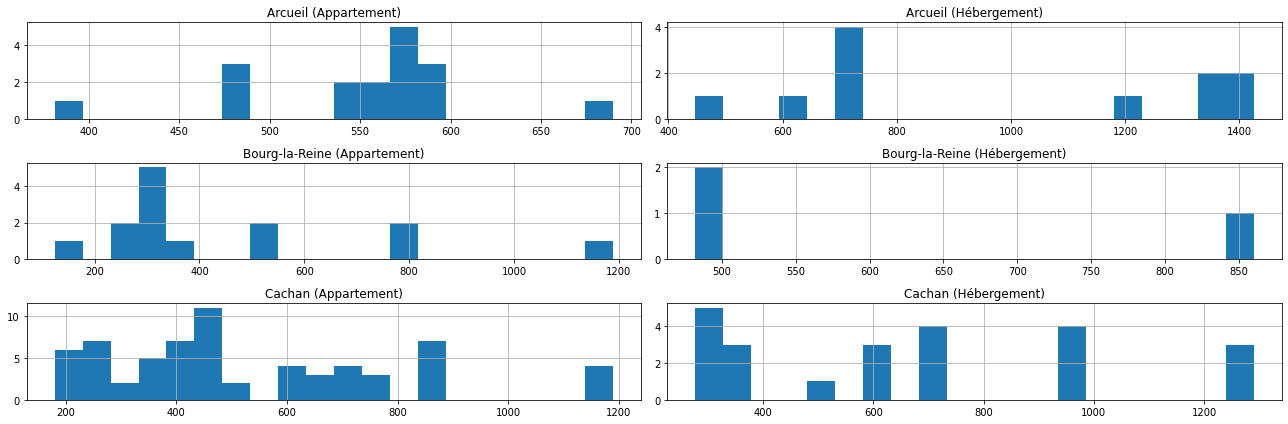

In [103]:
fig = plt.figure(figsize=(18, 6))
num_plot = 1
for ville in villes:
    vue = df[df.ville == ville]
    for type_ in ('Appartement', 'Hébergement'):
        fig.add_subplot(len(villes), 2, num_plot)
        plt.title(f'{ville} ({type_})')
        vue[vue.type == type_].prix.hist(bins=20)
        num_plot += 1
plt.tight_layout()

In [104]:
# Être nouveau augmente les prix
df.groupby('est_nouveau').prix.mean()

est_nouveau
False    586.500000
True     629.866667
Name: prix, dtype: float64

In [105]:
# Être professionnel aussi
df.groupby('est_professionnel').prix.mean()

est_professionnel
False    580.466102
True     670.375000
Name: prix, dtype: float64

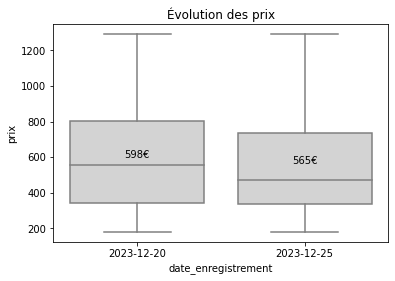

In [198]:
# Comment évoluent les prix ?
import seaborn as sns
vue = df[df.ville == 'Cachan']


sns.boxplot(x=vue.date_enregistrement, y=vue.prix, color='lightgray')
moyennes = vue.groupby('date_enregistrement').prix.mean()
for i, moyenne in enumerate(moyennes):
    plt.text(i, moyenne, f'{moyenne:.0f}€', ha='center')
plt.title('Évolution des prix');

## Suivi des logements dans le temps

In [170]:
vue = df[['date_enregistrement'] + clé + ['prix']].drop_duplicates()
gb = vue.groupby(clé).prix.apply(list).apply(pd.Series)
dates = list(map(lambda d: d.strftime('%Y-%m-%d'), vue.date_enregistrement.unique()))
gb.columns = dates
gb

2023-12-20  \
ville   type        description                                                      
Arcueil Appartement Appartement Cocon avec parking privé près de Paris       690.0   
                    Appartement duplex - Arcueil                             565.0   
                    Beau T3 à Arcueil à 3 min RER B « Laplace »              573.0   
                    Home sweet home in Paris                                 579.0   
                    L'Essentiel : Appartement lumineux proche de tout        381.0   
...                                                                            ...   
Cachan  Hébergement Maison entière à 2km de Paris pour les JO 2024           705.0   
                    Petite maison tout confort parking terrasse jardin       280.0   
                    Summer 2023 Cheerful 3-bedroom family home               340.0   
        Villa       Jardin fleuri tout près de Paris                         916.0   
                    Maison et jardin boisé A 10 minutes de Paris !           805.0   

                                                                        2023-12-25  
ville   type        description                                                     
Arcueil Appartement Appartement Cocon avec parking privé près de Paris         NaN  
                    Appartement duplex - Arcueil                             565.0  
                    Beau T3 à Arcueil à 3 min RER B « Laplace »                NaN  
                    Home sweet home in Paris                                 579.0  
                    L'Essentiel : Appartement lumineux proche de tout          NaN  
...                                                                            ...  
Cachan  Hébergement Maison entière à 2km de Paris pour les JO 2024           705.0  
                    Petite maison tout confort parking terrasse jardin       280.0  
                    Summer 2023 Cheerful 3-bedroom family home               340.0  
        Villa       Jardin fleuri tout près de Paris                         916.0  
                    Maison et jardin boisé A 10 minutes de Paris !             NaN  

[63 rows x 2 columns]

In [173]:
# Ceux qui changent de stratégie :
gb[gb['2023-12-20'] != gb['2023-12-25']].dropna(how='any')

,,,2023-12-20,2023-12-25
ville,type,description,,
Arcueil,Hébergement,La Maison Ensoleillée - 2 Chambres - RER B & M7,1425.0,1355.0
Cachan,Appartement,2P a 10 min à pied du RER B,389.0,380.0


## Annexes

In [122]:
# Recherche d'une clé primaire : 
variables_dynamiques = ['date_enregistrement', 'est_nouveau', 'note', 'nb_avis']
vue = df.drop(variables_dynamiques, axis=1).drop_duplicates()
vue[vue[clé].duplicated(keep=False)]

# --> les logements qui apparaissent sont ceux qui ont changé de stratégie de prix !
# --> la clé ['ville', 'type', 'description'] identifie donc un logement de façon unique

,type,ville,description,prix,nb_lits,nb_chambres,est_professionnel
41,Hébergement,Arcueil,La Maison Ensoleillée - 2 Chambres - RER B & M7,1425,NaN,NaN,False
57,Appartement,Cachan,2P a 10 min à pied du RER B,389,NaN,NaN,False
197,Appartement,Cachan,2P a 10 min à pied du RER B,380,NaN,NaN,False
239,Hébergement,Arcueil,La Maison Ensoleillée - 2 Chambres - RER B & M7,1355,NaN,NaN,False
